In [1]:
import importlib as imt
import datasets_v3 as ds3
import frame_autoencoder_v3 as fr
import catalog
import datasets_v0 as ds0
import utils
imt.reload(ds0)
imt.reload(fr)
imt.reload(ds3)
imt.reload(catalog)
imt.reload(utils)

<module 'catalog' from '/home/ubuntu/amzbinimg/src/catalog.py'>

In [2]:
import datetime as dt
import tensorflow as tf

import skimage
from skimage.io import imread
from skimage.io import imsave
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Activation, Dense, Input, InputLayer
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D

from tensorflow.keras.activations import relu

from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.callbacks import TensorBoard

## Run Prediction Model from Encoder

### load model

In [3]:
frame = fr.frame_autoencoder(batch_size = 256, 
                            kernel_size = 3, 
                            latent_dim = 1024, 
                            layer_filters = [16, 32, 16]
    )

In [4]:
# load dataset
X_train, X_test, y_train, y_test = ds0.load_data()

get_metadata: Available Images: 29312


In [5]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
# Prepare Datasets
frame.load_datagenerators(X_train, y_train, X_test, y_test, input_size = (128, 128))
frame.input_shape = (128, 128, 3)

In [48]:
frame.train_generator.reset()
frame.valid_generator.reset()
frame.test_generator.reset()

In [32]:
def soft_rmse(y_true, y_pred):
    return K.sqrt(  K.mean(K.cast_to_floatx ( K.square( K.argmax(y_true) - K.argmax(y_pred) )), axis=-1) )

In [49]:
# load models
frame.encoder = tf.keras.models.load_model("../model/encoder_reco_binary_6428.h5")
frame.inputs = frame.encoder.input
frame.load_decoder(build_decoder_predict)
frame.load_model_predict(build_model_predict)

In [41]:
frame.model_predict.summary()

Model: "model_predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 1024)              4205296   
_________________________________________________________________
decoder_predicter (Model)    (None, 6)                 2363142   
Total params: 6,568,438
Trainable params: 6,568,182
Non-trainable params: 256
_________________________________________________________________


In [42]:
frame.encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
tf_op_layer_Relu_6 (TensorFl (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 32)        128 

In [43]:
frame.decoder.summary()

Model: "decoder_predicter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1024)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_15 (Dense)             (None, 6)           

In [70]:
fr.print_model_properties(frame.encoder)

Layer 0 | Name: encoder_input | Trainable: True
Layer 1 | Name: conv2d | Trainable: True
Layer 2 | Name: batch_normalization | Trainable: False
Layer 3 | Name: tf_op_layer_Relu | Trainable: True
Layer 4 | Name: max_pooling2d | Trainable: True
Layer 5 | Name: conv2d_1 | Trainable: True
Layer 6 | Name: batch_normalization_1 | Trainable: False
Layer 7 | Name: tf_op_layer_Relu_1 | Trainable: True
Layer 8 | Name: max_pooling2d_1 | Trainable: True
Layer 9 | Name: conv2d_2 | Trainable: True
Layer 10 | Name: batch_normalization_2 | Trainable: False
Layer 11 | Name: tf_op_layer_Relu_2 | Trainable: True
Layer 12 | Name: max_pooling2d_2 | Trainable: True
Layer 13 | Name: flatten | Trainable: True
Layer 14 | Name: latent_vector | Trainable: True


In [71]:
fr.print_model_properties(frame.decoder)

Layer 0 | Name: decoder_input | Trainable: True
Layer 1 | Name: dense_18 | Trainable: True
Layer 2 | Name: dropout_12 | Trainable: True
Layer 3 | Name: dense_19 | Trainable: True
Layer 4 | Name: dropout_13 | Trainable: True
Layer 5 | Name: dense_20 | Trainable: True
Layer 6 | Name: dropout_14 | Trainable: True
Layer 7 | Name: dense_21 | Trainable: True


In [72]:
fr.print_model_properties(frame.model_predict)

Layer 0 | Name: encoder_input | Trainable: True
Layer 1 | Name: encoder | Trainable: True
Layer 2 | Name: decoder_predicter | Trainable: True


In [63]:
# set trainable layer to top layers only
fr.change_trainable_layers(frame.encoder, 9)

In [50]:
frame.encoder.trainable = False

In [51]:
print('\nFitting the model ... ...')
log_dir="../logs/fit/xception/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


Fitting the model ... ...


In [53]:
history = frame.model_predict.fit(
        x=frame.train_generator,
        #y=self.train_df['label'].values,
        #generator = train_generator,
        batch_size=None,
        epochs=40,
        verbose=1,
        validation_data=frame.valid_generator,
        #shuffle=False,
        #class_weight=None,
        #sample_weight=None,
        #initial_epoch=0,
        steps_per_epoch=frame.STEP_SIZE_TRAIN,
        validation_steps=frame.STEP_SIZE_VALID,
        #validation_freq=1,
        max_queue_size=frame.batch_size*8,
        #workers=4,
        use_multiprocessing=False,
        callbacks=[tensorboard_callback]
    )

Train for 73 steps, validate for 18 steps
Epoch 1/40
73/73 [==============================] - 23s 321ms/step - loss: 1.8350 - accuracy: 0.3078 - soft_rmse: 1.7113 - val_loss: 1.7822 - val_accuracy: 0.1799 - val_soft_rmse: 2.5252
Epoch 2/40
73/73 [==============================] - 23s 320ms/step - loss: 1.4033 - accuracy: 0.3618 - soft_rmse: 1.5266 - val_loss: 1.7829 - val_accuracy: 0.2064 - val_soft_rmse: 1.6278
Epoch 3/40
73/73 [==============================] - 23s 320ms/step - loss: 1.3554 - accuracy: 0.3813 - soft_rmse: 1.4873 - val_loss: 1.7762 - val_accuracy: 0.1819 - val_soft_rmse: 2.2850
Epoch 4/40
73/73 [==============================] - 23s 318ms/step - loss: 1.3299 - accuracy: 0.3989 - soft_rmse: 1.4326 - val_loss: 1.7808 - val_accuracy: 0.1860 - val_soft_rmse: 2.1490
Epoch 5/40
73/73 [==============================] - 23s 320ms/step - loss: 1.3084 - accuracy: 0.4054 - soft_rmse: 1.3966 - val_loss: 1.7538 - val_accuracy: 0.2350 - val_soft_rmse: 2.1098
Epoch 6/40
73/73 [=====

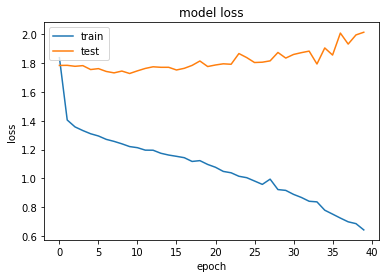

In [54]:
fr.plot_history(history)

In [36]:
print('\nValidationg the model ... ...')
log_dir="../logs/validation/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
frame.model_predict.evaluate(
        x=frame.test_generator,
        y=None,
        batch_size=None,
        verbose=1,
        sample_weight=None,
        steps=frame.STEP_SIZE_TEST,
        max_queue_size=frame.batch_size*8,
        #workers=1,
        use_multiprocessing=False,
        callbacks=[tensorboard_callback]
    )


Validationg the model ... ...
45/45 [==============================] - 2s 53ms/step - loss: 1543848.5583 - accuracy: 1.0000 - soft_rmse: 0.0000e+00


[1543848.5583333333, 1.0, 0.0]

In [37]:
pred = frame.model_predict.predict(x=frame.test_generator,
            steps=frame.STEP_SIZE_TEST,
            max_queue_size=frame.batch_size*8,
            #workers=8,
            use_multiprocessing=False,
            verbose=True)

45/45 [==============================] - 3s 59ms/step


In [38]:
pred.shape

(5760, 6)

In [53]:
y_hat = np.argmax(pred, axis=1)

In [57]:
y_hat[0:5]

array([0, 0, 0, 0, 0])

In [58]:
y_test[0:5]

array([4, 4, 2, 2, 3], dtype=uint8)

##### np.sum(y_hat)

In [47]:
def build_decoder_predict(frame):

    latent_inputs = Input(shape=(frame.latent_dim,), name='decoder_input')
    x = Dense(frame.latent_dim, activation='relu')(latent_inputs)
    x = Dropout(0.2)(x)
    x = Dense(frame.latent_dim, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(6, activation='softmax')(x)
    frame.decoder = Model(latent_inputs, outputs, name='decoder_predicter')

In [38]:
def build_model_predict(frame):
    frame.model_predict = Model(frame.inputs, frame.decoder(frame.encoder(frame.inputs)), name='model_predict')
    optimizer = optimizers.Adam(
        learning_rate=0.0008, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam'
    )
    frame.model_predict.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy', soft_rmse])

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def plot_metrics(rmse, acc):
    fig, ax1 = plt.subplots()
    x = np.arange(1, len(rmse)+1, 1)
    y1 = rmse
    ax1.plot(x, y1, 'b-')
    ax1.set_xlabel('Epoch')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    y2 = acc
    ax2.plot(x, y2, 'r-')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    #fig.savefig('../image/loss_vs_acc.png')
    plt.show()
    pass


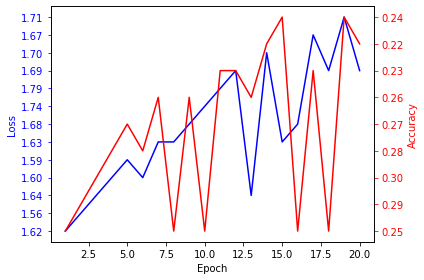

In [27]:
# load the pickled history files
val_acc = ['%.2f' % elem for elem in history.history.get('val_accuracy')]
val_loss = ['%.2f' % elem for elem in history.history.get('val_soft_rmse')]
train_acc = ['%.2f' % elem for elem in history.history.get('accuracy')]
train_loss = ['%.2f' % elem for elem in history.history.get('soft_rmse')]
plot_metrics(val_loss, val_acc)

In [22]:
val_acc = ['%.2f' % elem for elem in history.history.get('val_accuracy')]

In [26]:
len(val_acc)

20

In [15]:
history.hi

{'loss': [252909.6573791897,
  2500877.4360240446,
  7670992.770287677,
  15559957.70287677,
  26228618.694718763,
  38756153.48733362,
  53778268.99270073,
  70549411.40060112,
  89577657.11635895,
  109993347.14297982,
  130655726.58823529,
  156759943.62559038,
  179947673.67282096,
  208121372.88106483,
  234054358.87677115,
  264571822.22756547,
  294785817.51481324,
  324131611.4246458,
  362517396.9531988,
  392027302.03177327],
 'accuracy': [0.5552812,
  0.5333298,
  0.5298411,
  0.52307856,
  0.5213611,
  0.51663804,
  0.5176041,
  0.51400816,
  0.5139008,
  0.51255906,
  0.51030487,
  0.5115393,
  0.50848,
  0.5101438,
  0.5077823,
  0.50697726,
  0.5070309,
  0.504562,
  0.50466937,
  0.5057428],
 'soft_rmse': [2.366571,
  2.4145129,
  2.421135,
  2.4366498,
  2.4395883,
  2.4465578,
  2.442967,
  2.4512813,
  2.4474666,
  2.4570475,
  2.4554431,
  2.4532504,
  2.4639494,
  2.4596908,
  2.459221,
  2.4621089,
  2.4690213,
  2.4621518,
  2.4616132,
  2.4660044],
 'val_loss': 

In [60]:
y_train

array([3, 4, 3, ..., 5, 1, 5], dtype=uint8)

In [61]:
def soft_rmse(y_true, y_pred):
    return K.sqrt(  K.mean(K.cast_to_floatx ( K.square( K.argmax(y_true) - K.argmax(y_pred) )), axis=-1) )

In [ ]:
soft_rmse(pred)

In [68]:
y_true = tf.keras.utils.to_categorical(y_test)

In [67]:
pred

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.67486435, 0.02750359, 0.02277902, 0.14145926, 0.08211054,
        0.0512832 ]], dtype=float32)

In [72]:
soft_rmse(y_true[0:100], pred[0:100])

<tf.Tensor: id=23218, shape=(), dtype=float32, numpy=3.133688>

In [70]:
y_true.shape

(5863, 6)

In [71]:
pred.shape

(5760, 6)